I used Learned Similarity based Method to discover novel classes.

Steps : Given (Xl.Yl) as labeled set and Xu as unlabeled set of unique classes than labeled set

1) Train a binary classifier on (xi , xj) pairs taken from the labelled data and fed to the neural network . The network's parameters are tuned such that to get the results same as Yl.

2) Now feed the unlabelled data on the trained similarity classifier to get pairwise pseudo label matrix (symmetric) Y_u .

3) Now, this matrix is used as a
 target to train a classifer on Du and make the final class prediction Yu .

 I have used a mobile phone pricing dataset (2000 datapoints)(20 features)(4 classes) in which classes are price ranges [0,1,2,3] (low ,medium , high , very-high) which are targets. The Problem is to discover two more classes given the known 2 classes

So, I splitted the dataset into 2 halves [0,1] known classes & [2,3] novel classes .

So, 1000 datapoints are used to train the first classifier. After training is finished it is tested on the 100 samples from the training data to check that the tuning was success or not . (This is not a real test just checking that the model is accurate on train data values)




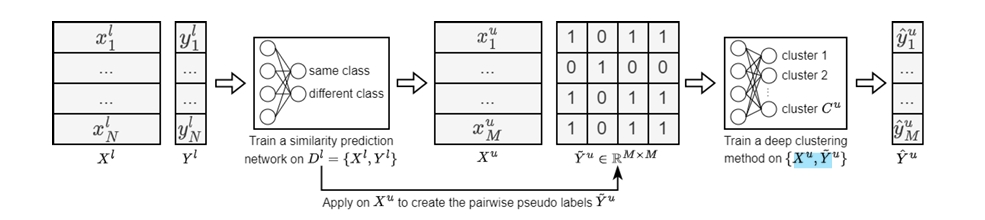

Methods like CCN and MCL are based on the above model

dataset used : https://www.kaggle.com/datasets/khwaishsaxena/mobile-phone-pricing-dataset/data

# Data preprocessing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import files
import pandas as pd
df = pd.read_csv("Mobile Phone Pricing.csv")
print(df.shape)
print(df['price_range'].value_counts())  # Check the class distribution


# Simulate some labeled data
'''X, Y = make_classification(n_samples=10000, n_features=20, n_classes=5, n_informative=15, n_clusters_per_class=1)
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.long)

# Train/test split
Xl_train, Xl_val, Yl_train, Yl_val = train_test_split(X, Y, test_size=0.2, stratify=Y)'''

(2000, 21)
price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64


'X, Y = make_classification(n_samples=10000, n_features=20, n_classes=5, n_informative=15, n_clusters_per_class=1)\nX = torch.tensor(X, dtype=torch.float32)\nY = torch.tensor(Y, dtype=torch.long)\n\n# Train/test split\nXl_train, Xl_val, Yl_train, Yl_val = train_test_split(X, Y, test_size=0.2, stratify=Y)'

In [ ]:
from sklearn.model_selection import train_test_split

# Separate Dl (seen classes: 0 and 1)
Dl = df[df['price_range'].isin([0, 1])]
Du = df[df['price_range'].isin([2, 3])]

# Ensure balanced 1000-1000 split
Dl = Dl.sample(n=1000, random_state=38)
Du = Du.sample(n=1000, random_state=45)
Dltst = Dl.sample(n=1000, random_state=45)
Xtst = Dltst.drop(columns=['price_range']).values
Ytst = Dltst['price_range'].values
# Separate features and labels
Xl = Dl.drop(columns=['price_range']).values
Yl = Dl['price_range'].values

Xu = Du.drop(columns=['price_range']).values
# (you can keep them for ground truths)
Yu_true = Du['price_range'].values

In [ ]:
Dl.head(10)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
1312,1142,1,1.1,0,0,1,6,0.5,198,4,...,739,1766,1273,19,0,6,1,0,0,1
458,664,0,1.2,1,0,0,28,0.9,106,5,...,754,1497,2042,17,15,19,1,1,0,1
19,682,1,0.5,0,4,0,19,1.0,121,4,...,902,1064,2337,11,1,18,0,1,1,1
207,1265,0,1.5,0,7,0,49,0.7,182,5,...,690,836,1362,5,0,12,0,0,1,1
880,1554,0,2.7,1,3,1,47,0.7,185,5,...,319,1367,509,12,3,19,1,0,0,0
674,1034,0,2.6,1,2,1,45,0.3,190,3,...,182,1293,969,15,1,7,1,0,0,0
1528,1028,1,2.8,0,1,1,30,0.1,193,1,...,1801,1923,1424,18,4,13,1,0,1,1
1931,1854,0,0.9,1,0,1,33,0.4,195,1,...,665,718,1675,14,12,9,1,0,1,1
1662,1751,0,2.5,0,1,0,4,0.6,146,8,...,1499,1952,1155,19,14,12,0,1,1,1
1838,720,1,0.9,1,12,1,14,0.8,165,4,...,366,1234,1086,14,7,3,1,1,0,0


In [ ]:
Du.head(10)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
1428,1823,0,2.8,1,11,0,10,0.6,81,8,...,362,1250,1812,5,0,19,1,1,1,2
460,1742,0,2.3,1,9,1,43,0.4,170,7,...,453,681,2610,12,3,10,1,0,1,2
651,1762,1,2.5,0,10,1,15,0.3,107,8,...,1103,1364,2183,8,3,11,1,1,0,2
1941,1522,0,2.2,0,4,0,21,0.7,162,6,...,533,1696,3767,15,9,16,0,0,1,3
1823,1493,0,1.5,1,13,0,53,0.5,102,5,...,240,1414,2083,19,15,20,0,1,1,2
1275,1733,1,1.5,1,4,1,6,0.9,170,1,...,590,997,3488,6,4,10,1,1,1,3
487,1663,1,2.5,1,13,1,27,0.3,169,4,...,831,1439,2084,7,1,18,1,0,0,2
1223,514,1,1.6,0,7,1,37,0.1,172,1,...,956,1723,3392,12,8,5,1,1,1,3
65,616,0,1.9,1,13,1,44,0.8,81,3,...,651,1618,3366,18,8,13,1,1,0,3
1827,1692,0,2.1,0,4,1,2,0.9,106,1,...,1899,1904,3779,9,3,7,1,1,1,3


In [ ]:
Dltst.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
1913,1969,0,1.2,1,9,0,63,0.2,132,4,...,390,756,298,10,1,10,1,1,0,0
1943,719,0,2.9,0,7,0,6,0.7,102,6,...,405,1141,841,9,1,2,1,0,0,0
669,723,0,0.5,0,0,1,3,0.2,168,4,...,920,1748,1851,15,3,16,1,0,0,1
440,1310,1,2.3,1,6,0,57,0.9,135,8,...,449,889,1175,16,0,8,0,0,0,0
92,885,0,2.3,1,0,1,15,0.4,103,7,...,769,802,1410,16,10,5,1,1,1,0


In [ ]:
Xl = torch.tensor(Xl, dtype=torch.float32)
Yl = torch.tensor(Yl, dtype=torch.long)

Xu = torch.tensor(Xu, dtype=torch.float32)
Yu_true = torch.tensor(Yu_true, dtype=torch.long)  # Only for evaluation

Xtst = torch.tensor(Xtst, dtype=torch.float32)
Ytst = torch.tensor(Ytst, dtype=torch.long)
print(Xl.shape)
print(Yl.shape)
print(Xu.shape)
print(Yu_true.shape)

torch.Size([1000, 20])
torch.Size([1000])
torch.Size([1000, 20])
torch.Size([1000])


# Starting Step 1

In [ ]:
def generate_pairs(X, Y, num_pairs):
    pairs = []
    labels = []

    n = len(X)
    for _ in range(num_pairs):
        i, j = random.randint(0, n-1), random.randint(0, n-1)
        pairs.append((X[i], X[j]))
        labels.append(int(Y[i] == Y[j]))  # 1 if same class, else 0

    return pairs, torch.tensor(labels, dtype=torch.float32)

In [ ]:
from sklearn.metrics import confusion_matrix
import torch

def generate_all_pairs(X, Y):
    n = len(X)
    pairs = []
    labels = []

    for i in range(n):
        for j in range(n):
            pairs.append((X[i], X[j]))
            labels.append(int(Y[i] == Y[j]))  # 1 if same class, else 0

    return pairs, torch.tensor(labels, dtype=torch.float32)

In [ ]:
train_pairs, train_labels = generate_all_pairs(Xl, Yl)
val_pairs, val_labels = generate_all_pairs(Xtst, Ytst)

In [ ]:
class PairwiseDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x1, x2 = self.pairs[idx]
        return x1, x2, self.labels[idx]

In [ ]:
train_dataset = PairwiseDataset(train_pairs, train_labels)
val_dataset = PairwiseDataset(val_pairs, val_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [ ]:
class SimilarityNetwork(nn.Module):
    def __init__(self, input_dim):
        super(SimilarityNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Binary output
        )

    def forward(self, x1, x2):
        combined = torch.cat((x1, x2), dim=1)
        return self.fc(combined).squeeze() #squeeze() will convert [64,1] to [64]

In [ ]:
model = SimilarityNetwork(input_dim=20)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Training loop
for epoch in range(20):
    model.train()
    total_loss = 0
    for x1, x2, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(x1, x2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Train Loss: {total_loss / len(train_loader):.4f}")


Epoch 1 - Train Loss: 0.3119
Epoch 2 - Train Loss: 0.1870
Epoch 3 - Train Loss: 0.1448
Epoch 4 - Train Loss: 0.1206
Epoch 5 - Train Loss: 0.1050
Epoch 6 - Train Loss: 0.0934
Epoch 7 - Train Loss: 0.0832
Epoch 8 - Train Loss: 0.0745
Epoch 9 - Train Loss: 0.0668
Epoch 10 - Train Loss: 0.0601
Epoch 11 - Train Loss: 0.0536
Epoch 12 - Train Loss: 0.0467
Epoch 13 - Train Loss: 0.0415
Epoch 14 - Train Loss: 0.0364
Epoch 15 - Train Loss: 0.0333
Epoch 16 - Train Loss: 0.0308
Epoch 17 - Train Loss: 0.0311
Epoch 18 - Train Loss: 0.0269
Epoch 19 - Train Loss: 0.0259
Epoch 20 - Train Loss: 0.0249


In [ ]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x1, x2, labels in loader:
            outputs = model(x1, x2)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

acc = evaluate(model, val_loader)
print(f"Validation Accuracy: {acc * 100:.2f}%")


Validation Accuracy: 99.85%


In [ ]:
def evaluate_similarity_model(model, val_pairs , val_labels):
    model.eval()
    with torch.no_grad():
        x1_batch = torch.stack([p[0] for p in val_pairs])
        x2_batch = torch.stack([p[1] for p in val_pairs])

        preds = model(x1_batch, x2_batch)
        preds_bin = (preds >= 0.5).int()  # threshold at 0.5

        cm = confusion_matrix(val_labels.int(), preds_bin)
        return cm

Confusion Matrix:
[[499715    285]
 [  1209 498791]]


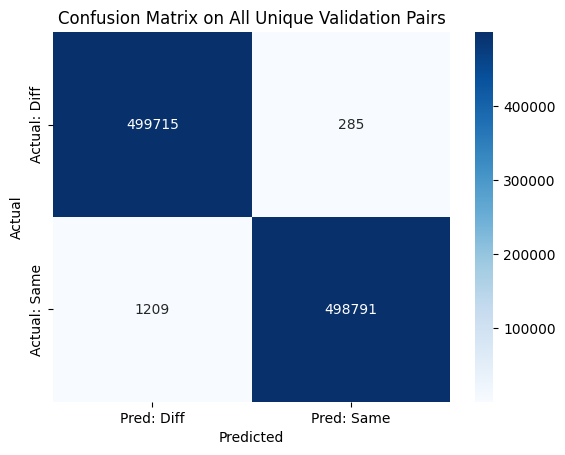

Accuracy: 99.85%


In [ ]:
cm = evaluate_similarity_model(model, val_pairs, val_labels)

print("Confusion Matrix:")
print(cm)

# Optional: format it nicely
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred: Diff", "Pred: Same"], yticklabels=["Actual: Diff", "Actual: Same"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on All Unique Validation Pairs")
plt.show()
accuracy_score = (cm[0, 0] + cm[1, 1]) / (cm[0, 0] + cm[0, 1] + cm[1, 0] + cm[1, 1])
print(f"Accuracy: {accuracy_score * 100:.2f}%")

#Step 2

In [ ]:
def generate_pseudo_affinity_matrix(model, Du):
    model.eval()
    n = len(Du)
    Yu = torch.zeros((n, n))

    with torch.no_grad():
        for i in range(n):
            for j in range(i+1,n):  # Only upper triangle
                sim = model(Du[i].unsqueeze(0), Du[j].unsqueeze(0))
                Yu[i, j] = sim
                Yu[j, i] = sim
                  # Make it symmetric

    return Yu

In [ ]:
from sklearn.cluster import SpectralClustering

def cluster_with_affinity(Yu, n_clusters):
    clustering = SpectralClustering(
        n_clusters=n_clusters,
        affinity='precomputed',
        assign_labels='kmeans',
        random_state=83
    )
    labels = clustering.fit_predict(Yu.cpu().numpy())
    return labels  # predicted cluster IDs (novel classes)

In [ ]:
Yu = generate_pseudo_affinity_matrix(model, Xu)

# Optional: threshold if you're confident about similarity cutoff
#Yu = (Yu >= 0.5).float()

# Choose number of novel classes in Du (manually or estimated)
n_novel_classes = 2
cluster_labels = cluster_with_affinity(Yu, n_clusters=n_novel_classes)

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(Yu_true, cluster_labels)
nmi = normalized_mutual_info_score(Yu_true, cluster_labels)
print(f"ARI: {ari:.4f}, NMI: {nmi:.4f}")

ARI: 0.0000, NMI: 0.0020


In [ ]:
from scipy.optimize import linear_sum_assignment as linear_assignment
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    row_ind, col_ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(row_ind, col_ind)]) * 1.0 / y_pred.size

In [ ]:
acc = cluster_acc(Yu_true.numpy(), cluster_labels)
print(acc)

0.501


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume X = features, y = price_range
X = df.drop(columns=['price_range'])
y = df['price_range']

# Train random forest
rf = RandomForestClassifier()
rf.fit(X, y)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index)
plt.title('Feature Importance from Random Forest')
plt.show()


In [ ]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

mi_series.plot(kind='barh', figsize=(10, 6))
plt.title("Mutual Information with Target")
plt.show()
